In [27]:
from os.path import join

import numpy as np
import pymagicc
from pymagicc import zero_emissions, MAGICC6
from pymagicc.io import MAGICCData
from fair.forward import fair_scm
from openscm.highlevel import ScmDataFrame, df_append
from progressbar import progressbar

In [28]:
FIGSIZE = (16, 9)

run MAGICC and FaIR from one dataframe

In [29]:
def run_fair_co2_emms_other_rf(sdf, **kwargs):
    rf_ext = sdf.filter(variable="Radiative Forcing|Extra").timeseries().values.squeeze()
    emms_co2 = sdf.filter(variable="Emissions|CO2|MAGICC Fossil and Industrial").timeseries().values.squeeze()
    time = sdf.timeseries().columns
    
    C, F, T = fair_scm(
        emissions=emms_co2,
        other_rf=rf_ext,
        useMultigas=False,
        **kwargs
    )

    res = ScmDataFrame(
        np.array([emms_co2, C, F, T]).T,
        columns={
            "index": time,
            "scenario": ["idealised"],
            "model": ["unspecified"],
            "climate_model": ["FaIR"],
            # need to make a decision about fossil/land split
            "variable": ["Emissions|CO2|MAGICC Fossil and Industrial", "Atmospheric Concentrations|CO2", "Radiative Forcing", "Surface Temperature"],
            "unit": ["GtC/yr", "ppm", "W/m^2", "K"],
            "region": ["World"],
        },
    )
    
    return res

In [30]:
def run_magicc_co2_emms_other_rf(sdf, magicc_inst, **kwargs):
    magicc_inst.set_zero_config()  
    
    forcing_ext_filename = "EXTERNAL_RF.IN"
    forcing_ext = MAGICCData(sdf.filter(variable="Radiative Forcing|Extra").timeseries())
    forcing_ext.metadata = {"header": "External radiative forcing input"}
    forcing_ext.write(
        join(magicc_inst.run_dir, forcing_ext_filename), 
        magicc_inst.version
    )
    
    df = zero_emissions.timeseries()
    df.loc[
        (
            df.index.get_level_values("variable")
            == "Emissions|CO2|MAGICC Fossil and Industrial"
        ),
        :,
    ] = emms_fossil_co2
    scen = MAGICCData(df)

    res = magicc.run(
        scen,
        endyear=scen["time"].max().year,
        co2_switchfromconc2emis_year=min(scen["time"]).year,
        rf_extra_read=1,
        file_extra_rf=forcing_ext_filename,
        rf_total_runmodus="ALL",  # default but just in case
        rf_initialization_method="ZEROSTARTSHIFT",  # this is default but to be sure 
        rf_total_constantafteryr=5000,
        **kwargs
    )
    
    return res

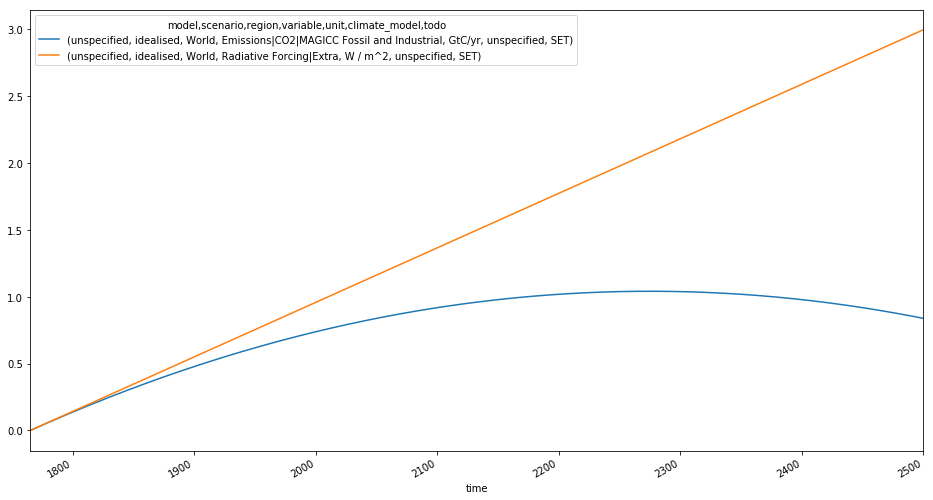

In [54]:
df = zero_emissions.timeseries()
time = zero_emissions["time"]  # if you modify time, I don't know what will happen
emms_fossil_co2 = (
    np.linspace(0, 3, len(time))
    - (1 + (np.arange(len(time)) - 500) / 500)**2
)
# emms_fossil_co2 = 0*np.linspace(0, 3, len(time))
forcing_external = 3.0 * np.arange(0, len(time)) / len(time)
scen = ScmDataFrame(
    np.array([emms_fossil_co2, forcing_external]).T,
    columns={
        "index": time,
        "scenario": ["idealised"],
        "model": ["unspecified"],
        "climate_model": ["unspecified"],
        # need to make a decision about fossil/land split
        "variable": ["Emissions|CO2|MAGICC Fossil and Industrial", "Radiative Forcing|Extra"],
        "unit": ["GtC/yr", "W / m^2"],
        "todo": ["SET"],
        "region": ["World"],
    },
)
scen.timeseries().T.plot(figsize=FIGSIZE);

In [55]:
ecs = [2, 3, 4]
config = {
    "MAGICC6": [{"core_climatesensitivity": v} for v in ecs],
    "FAIR": [{"tcrecs": np.array([3/4*v, v])} for v in ecs],
}

In [56]:
res = []
for model, cfg_list in config.items():
    print("running {}".format(model))
    if model == "MAGICC6":
        with MAGICC6() as magicc:
            for cfg in progressbar(cfg_list):
                this_run = run_magicc_co2_emms_other_rf(
                    scen,
                    magicc,
                    **cfg,
                )
                for k, v in cfg.items():
                    if k == "core_climatesensitivity":
                        k = "ecs"
                    this_run.set_meta(v, name=k)
                    
                res.append(this_run)
    else:
        for cfg in progressbar(cfg_list):
            this_run = run_fair_co2_emms_other_rf(
                scen,
                **cfg,
            )
            for k, v in cfg.items():
                if k == "tcrecs":
                    this_run.set_meta(v[0], name="tcr")
                    this_run.set_meta(v[1], name="ecs")
                else:
                    this_run.set_meta(v, name=k)
                    
            res.append(this_run)
            
res = df_append(res)

running MAGICC6


100% (3 of 3) |##########################| Elapsed Time: 0:00:10 Time:  0:00:10
N/A% (0 of 3) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

running FAIR


100% (3 of 3) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [57]:
res.filter(
    variable="Surface Temperature", 
    region="World"
).timeseries().tail()

time                                                                               1765-01-01 00:00:00  \
model       scenario  region variable            unit climate_model ecs tcr  todo                        
unspecified idealised World  Surface Temperature K    MAGICC6       3.0 NaN  N/A                   0.0   
                                                                    4.0 NaN  N/A                   0.0   
                                                      FaIR          2.0 1.50 NaN                   0.0   
                                                                    3.0 2.25 NaN                   0.0   
                                                                    4.0 3.00 NaN                   0.0   

time                                                                               1766-01-01 00:00:00  \
model       scenario  region variable            unit climate_model ecs tcr  todo                        
unspecified idealised World  Surface Temperature K    MAGICC6       3.0 NaN  N/A              0.000589   
                                                                    4.0 NaN  N/A              0.000616   
                                                      FaIR          2.0 1.50 NaN              0.000369   
                                                                    3.0 2.25 NaN              0.000553   
                                                                    4.0 3.00 NaN              0.000737   

time                                                                               1767-01-01 00:00:00  \
model       scenario  region variable            unit climate_model ecs tcr  todo                        
unspecified idealised World  Surface Temperature K    MAGICC6       3.0 NaN  N/A              0.001549   
                                                                    4.0 NaN  N/A              0.001640   
                                                      FaIR          2.0 1.50 NaN              0.001029   
                                                                    3.0 2.25 NaN              0.001544   
                                                                    4.0 3.00 NaN              0.002058   

time                                                                               1768-01-01 00:00:00  \
model       scenario  region variable            unit climate_model ecs tcr  todo                        
unspecified idealised World  Surface Temperature K    MAGICC6       3.0 NaN  N/A              0.002718   
                                                                    4.0 NaN  N/A              0.002902   
                                                      FaIR          2.0 1.50 NaN              0.001921   
                                                                    3.0 2.25 NaN              0.002881   
                                                                    4.0 3.00 NaN              0.003841   

time                                                                               1769-01-01 00:00:00  \
model       scenario  region variable            unit climate_model ecs tcr  todo                        
unspecified idealised World  Surface Temperature K    MAGICC6       3.0 NaN  N/A              0.004038   
                                                                    4.0 NaN  N/A              0.004344   
                                                      FaIR          2.0 1.50 NaN              0.002996   
                                                                    3.0 2.25 NaN              0.004494   
                                                                    4.0 3.00 NaN              0.005992   

time                                                                               1770-01-01 00:00:00  \
model       scenario  region variable            unit climate_model ecs tcr  todo                        
unspecified idealised World  Surface Temperature K    MAGICC6       3.0 N

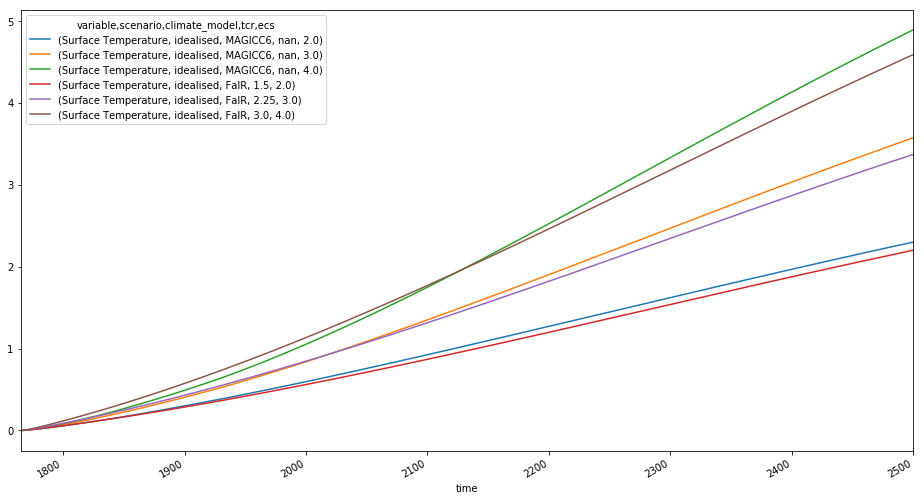

In [58]:
# don't know why I have to hack around pyam plotting, climate_model column not recognised?
res.filter(
    variable="Surface Temperature", 
    region="World"
).timeseries(meta=["variable", "scenario", "climate_model", "tcr", "ecs"]).T.plot(figsize=FIGSIZE);

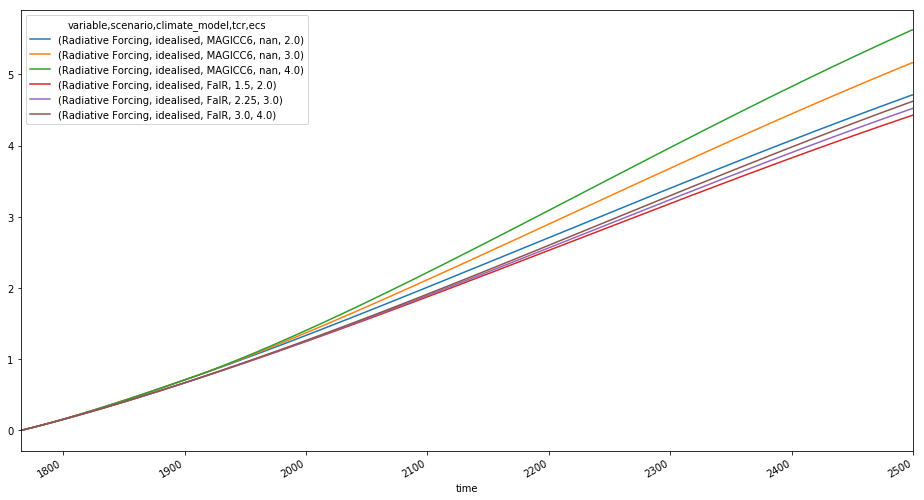

In [59]:
# you can see the effect of FaIR and MAGICC's outgassing on RF here
res.filter(
    variable="Radiative Forcing", 
    region="World"
).timeseries(meta=["variable", "scenario", "climate_model", "tcr", "ecs"]).T.plot(figsize=FIGSIZE);

In [50]:
# res.filter(
#     variable="Radiative Forcing|CO2", 
#     region="World"
# ).timeseries().T.plot();